In [1]:
# CHECK IF RUNNING INSIDE GOOGLE.COLAB

import os
import sys

IN_COLAB = 'google.colab' in sys.modules
CLONED = 0
if IN_COLAB and not CLONED:
    # clone the repo
    !git clone https://github.com/technogleb/ts_walkthrough
    CLONED = 1
    # append to sys.path
    sys.path.append('/content/ts_walkthrough')
    # change working directory to project root
    os.chdir('/content/ts_walkthrough')
    # install requirements
    !pip install -r requirements.txt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

sys.path.append(str(Path.cwd().parent))


import matplotlib.pyplot as plt
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PowerTransformer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller

import plotting
from load_dataset import Dataset




In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dataset = Dataset('../data/dataset/')


In [6]:
ts = dataset['international-airline-passengers.csv']
ts.index = ts.index.map(pd.to_datetime)

/Users/19515364/PycharmProjects/ts_march_2023/load_dataset.py:34: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ts = pd.read_csv(


In [7]:
143*0.7

100.1

In [8]:
ts, ts_test = ts[:100], ts[100:]

<Axes: xlabel='1949-01'>

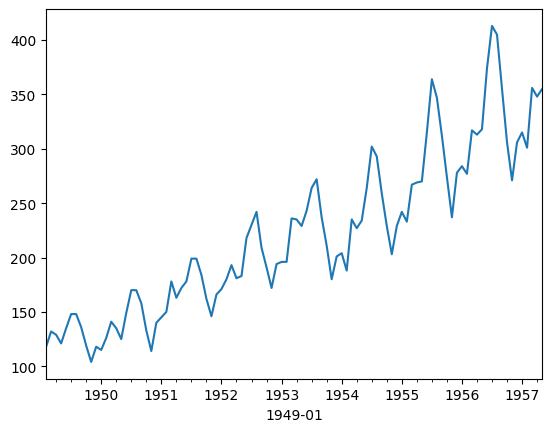

In [9]:
ts.plot()


<Axes: xlabel='1949-01'>

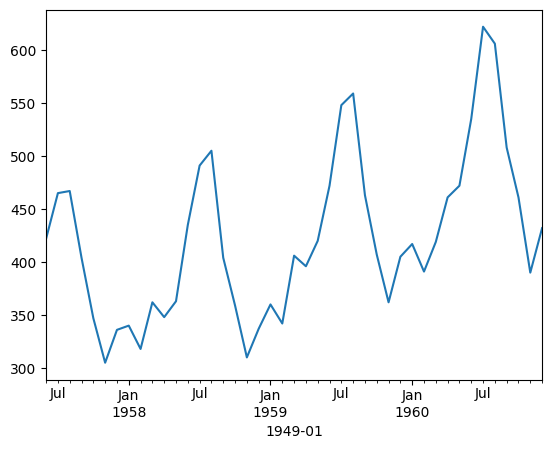

In [10]:
ts_test.plot()

#### Задание 1. Box-Jenkins approach
1. Убрать гетероскедастичность при помощи логарифмирования.
2. Продифференцировать разными способами и узнать нужный порядок дифференцирования d, D, анализируя
   получившийся ряд при помощи графика acf_plot и теста дикки-фуллера.
3. Найти (если модель разделима) или оценить (если не разделима) параметры (q, Q), (p, P) по графикам acf, pacf продифференцированного ряда.
4. Обучить модель SARIMAX и попробовать сделать предсказания исходного ряда.
5. Критерий хорошей модели (в идеале) - стационарные остатки.

<Axes: xlabel='1949-01'>

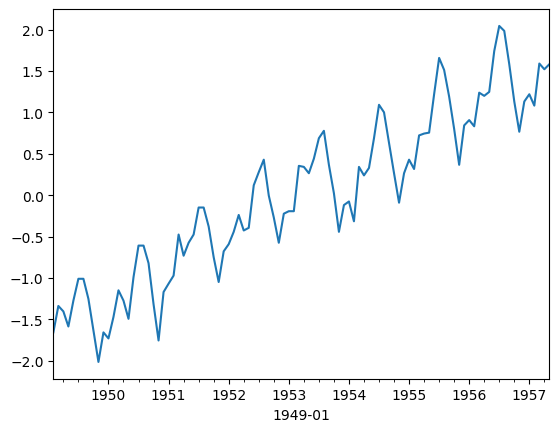

In [11]:
transformer = PowerTransformer()

ts_transformed = pd.Series(transformer.fit_transform(ts.values.reshape(-1, 1)).reshape((-1,)), index=ts.index)
ts_transformed.plot()

/Users/19515364/PycharmProjects/ts_march_2023/venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


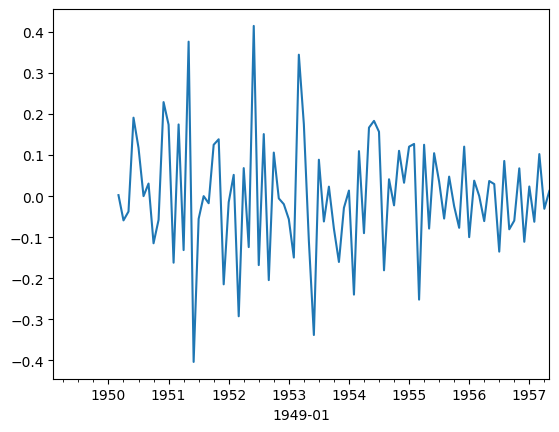

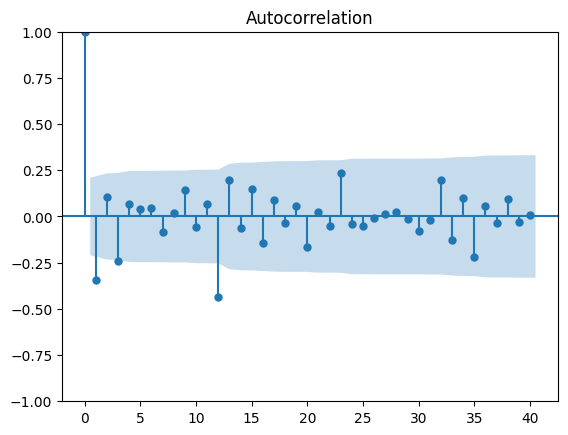

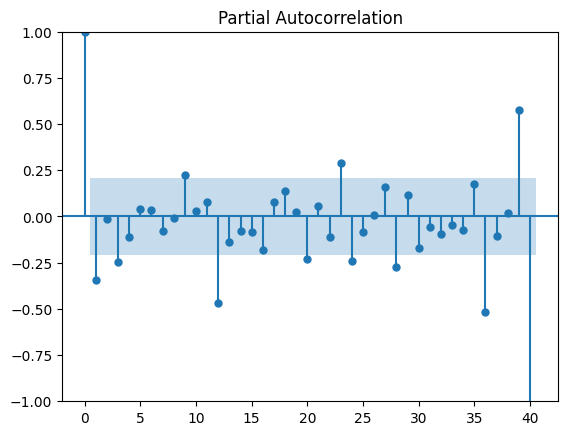

In [12]:
ts_transformed.diff().diff(12).plot()

plot_acf(ts_transformed.diff().diff(12).dropna(), lags=40);
plot_pacf(ts_transformed.diff().diff(12).dropna(), lags=40);

In [13]:
adfuller(ts_transformed.diff(12).diff().dropna())[1]

0.015508237328551753

# отлично, вердикт о стационарности подтвержден, (d, D) = (1, 1)

значит P = 1, итак (p, P) = (1, 2)


In [14]:
pdq = (1, 1, 0)
PDQ = (2, 1, 0, 12)
model = sarimax.SARIMAX(ts_transformed, order=pdq, seasonal_order=PDQ)

/Users/19515364/PycharmProjects/ts_march_2023/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/19515364/PycharmProjects/ts_march_2023/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
res = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.02908D-01    |proj g|=  1.81895D+00

At iterate    5    f= -6.25188D-01    |proj g|=  1.32306D-01

At iterate   10    f= -6.27983D-01    |proj g|=  1.27888D-02

At iterate   15    f= -6.28008D-01    |proj g|=  2.60870D-02


 This problem is unconstrained.



At iterate   20    f= -6.28019D-01    |proj g|=  1.82118D-03

At iterate   25    f= -6.28020D-01    |proj g|=  6.68861D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   1.326D-04  -6.280D-01
  F = -0.62801979455959023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [16]:
preds = res.forecast(43)

In [17]:
preds_train = res.predict()

In [18]:
def inverse_series(series, transformer=transformer):
    ts_transformed = pd.Series(transformer.inverse_transform(series.values.reshape(-1, 1)).reshape((-1,)), index=series.index)
    return ts_transformed

In [19]:
plotting.plot_ts(inverse_series(ts_transformed), inverse_series(preds), inverse_series(preds_train), ts_test)

Loading BokehJS ...

In [20]:
resid = (pd.Series(transformer.inverse_transform(preds.values.reshape(-1, 1)).reshape((-1,)), index=preds.index) - ts_test)
resid_tr = (pd.Series(transformer.inverse_transform(preds_train.values.reshape(-1, 1)).reshape((-1,)), index=preds_train.index) - ts)

<Axes: >

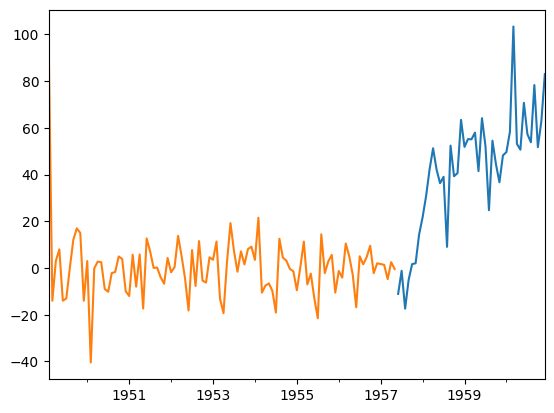

In [21]:
resid.plot()
resid_tr.plot()

/Users/19515364/PycharmProjects/ts_march_2023/venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


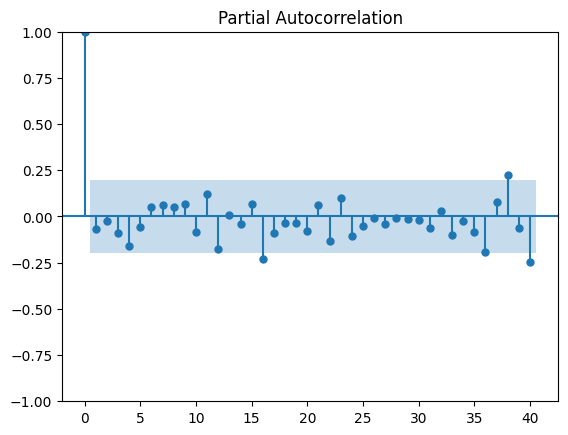

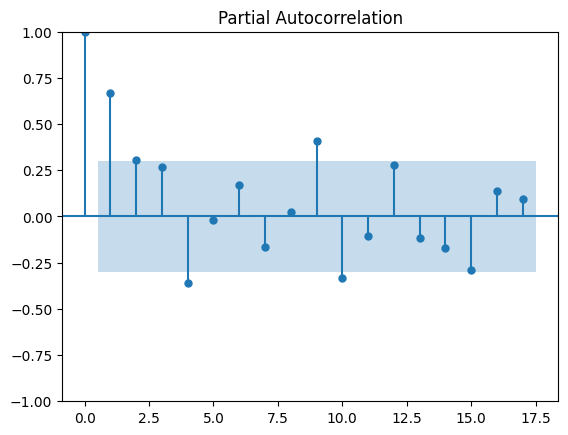

In [22]:
plot_pacf(resid_tr, lags=40);
plot_pacf(resid);

In [23]:
adfuller(resid_tr.dropna())[1]


9.390108296159355e-27

In [24]:
adfuller(resid.dropna())[1]

0.09096214610076203

На трейне остатки стационарны и без значимых корреляций, на тесте - отвергаем гипотезу о стационарности(

#### Задание 2. (используя auto-arima)
1. Установить аналог auto-arima из R, библиотеку pmdarima (pip install pmdarima)
2. Обучить модель, используя функцию auto_arima, передав в нее нужные параметры.

In [25]:
# на вход подается ряд со всеми преобразованиями кроме дифференцирования, границы поиска параметров p, q, P, Q, 
# периодом сезонности m, параметрами дифференцирования d, D
model = auto_arima(
     ts_transformed, start_p=0, start_q=0,
     max_p=4, max_q=4, m=12,
     start_P=0, start_Q=0, seasonal=True,
     d=1, D=2, trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=False
)

 ARIMA(0,1,0)(0,2,0)[12]             : AIC=10.528, Time=0.04 sec
 ARIMA(0,1,0)(0,2,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,2,2)[12]             : AIC=-54.475, Time=1.79 sec
 ARIMA(0,1,0)(1,2,0)[12]             : AIC=-22.861, Time=0.16 sec
 ARIMA(0,1,0)(1,2,1)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(1,2,2)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=-41.048, Time=0.36 sec
 ARIMA(0,1,0)(2,2,1)[12]             : AIC=inf, Time=1.68 sec
 ARIMA(0,1,0)(2,2,2)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(0,1,1)(0,2,0)[12]             : AIC=3.116, Time=0.05 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=0.66 sec
 ARIMA(0,1,1)(0,2,2)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,1)(1,2,0)[12]             : AIC=-34.550, Time=0.22 sec
 ARIMA(0,1,1)(1,2,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(0,1,1)(1,2,2)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(0,1,1)(2,2,0)[12]             : AIC=-47.82

In [26]:
model

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(0, 2, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [27]:
preds_auto = model.predict(len(ts_test))

In [28]:
plotting.plot_ts(inverse_series(ts_transformed), ts_test, inverse_series(preds_auto))

Loading BokehJS ...

In [29]:

print(f'Auto Sarima   MSE {mse(inverse_series(preds_auto), ts_test):.2f}')
print(f'manual sarima MSE {mse(inverse_series(preds), ts_test):.2f}')

Auto Sarima   MSE 1286.70
manual sarima MSE 2416.83


## Выводы

* auto arima подобрал параметры получше - MSE на тесте ниже
* отличия только в 1 параметре
* вручную удалось на трейн получить остатки стационарные